<a href="https://colab.research.google.com/github/pcoiffet/pytorch_course/blob/main/workflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Running tensors on GPU

##1. Getting a GPU

Deep learning algorithms require a lot of numerical operations.

And by default these operations are often done on a CPU (computer processing unit).

However, there's another common piece of hardware called a GPU (graphics processing unit), which is often much faster at performing the specific types of operations neural networks need (matrix multiplications) than CPUs.

Your computer might have one.

If so, you should look to use it whenever you can to train neural networks because chances are it'll speed up the training time dramatically.

There are a few ways to first get access to a GPU and secondly get PyTorch to use the GPU.

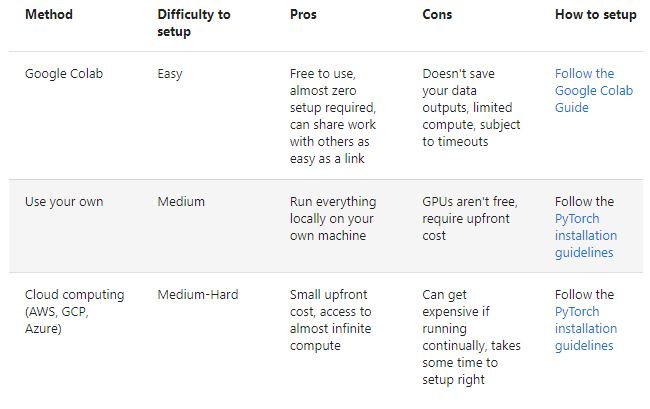

In [ ]:
import torch
torch.__version__

'2.1.0+cu118'

##2. Getting PyTorch to run on the GPU


Once you've got a GPU ready to access, the next step is getting PyTorch to use for storing data (tensors) and computing on data (performing operations on tensors).

To do so, you can use the torch.cuda package.

Rather than talk about it, let's try it out.

You can test if PyTorch has access to a GPU using torch.cuda.is_available().

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Tue Nov  7 18:05:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Set device type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

If the above output "cuda" it means we can set all of our PyTorch code to use the available CUDA device (a GPU) and if it output "cpu", our PyTorch code will stick with the CPU.

In [ ]:
# Count number of devices
torch.cuda.device_count()

1

## 3. Putting tensors (and models) on the GPU


You can put tensors (and models) on a specific device by calling to(device) on them. Where device is the target device you'd like the tensor (or model) to go to.

Why do this?

GPUs offer far faster numerical computing than CPUs do and if a GPU isn't available, because of our device agnostic code, it'll run on the CPU.

In [ ]:
# Create tensor (default on CPU)
tensor = torch.tensor([1, 2, 3])

# Tensor not on GPU
print(tensor, tensor.device)

# Move tensor to GPU (if available)
tensor_on_gpu = tensor.to(device)
tensor_on_gpu

tensor([1, 2, 3]) cpu


tensor([1, 2, 3], device='cuda:0')

Notice the second tensor has device='cuda:0', this means it's stored on the 0th GPU available (GPUs are 0 indexed, if two GPUs were available, they'd be 'cuda:0' and 'cuda:1' respectively, up to 'cuda:n').


## 4. Moving tensors back to the CPU

In [ ]:
# If tensor is on GPU, can't transform it to NumPy (this will error)
tensor_on_gpu.numpy()

TypeError: ignored

to get a tensor back to CPU and usable with NumPy we can use Tensor.cpu().

This copies the tensor to CPU memory so it's usable with CPUs.

In [ ]:
# Instead, copy the tensor back to cpu
tensor_back_on_cpu = tensor_on_gpu.cpu().numpy()
tensor_back_on_cpu

array([1, 2, 3])

In [ ]:
tensor_on_gpu

tensor([1, 2, 3], device='cuda:0')

#Workflow

The essence of machine learning and deep learning is to take some data from the past, build an algorithm (like a neural network) to discover patterns in it and use the discoverd patterns to predict the future.

There are many ways to do this and many new ways are being discovered all the time.

##1. Data (preparing and loading)

In [ ]:
import torch

In [ ]:
 # Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Split data into training and test sets


We've got some data.

But before we build a model we need to split it up.

One of most important steps in a machine learning project is creating a training and test set (and when required, a validation set).

Each split of the dataset serves a specific purpose:

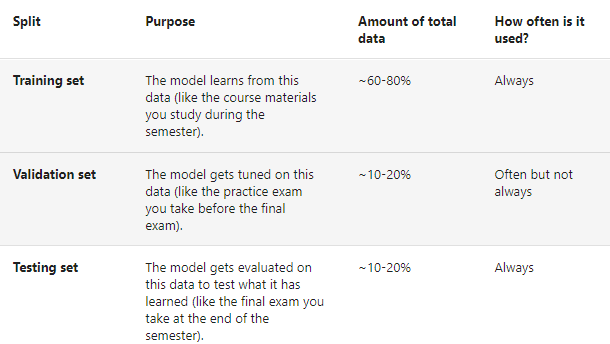

In [ ]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

The model we create is going to try and learn the relationship between X_train & y_train and then we will evaluate what it learns on X_test and y_test.



In [ ]:
import matplotlib.pyplot as plt

def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

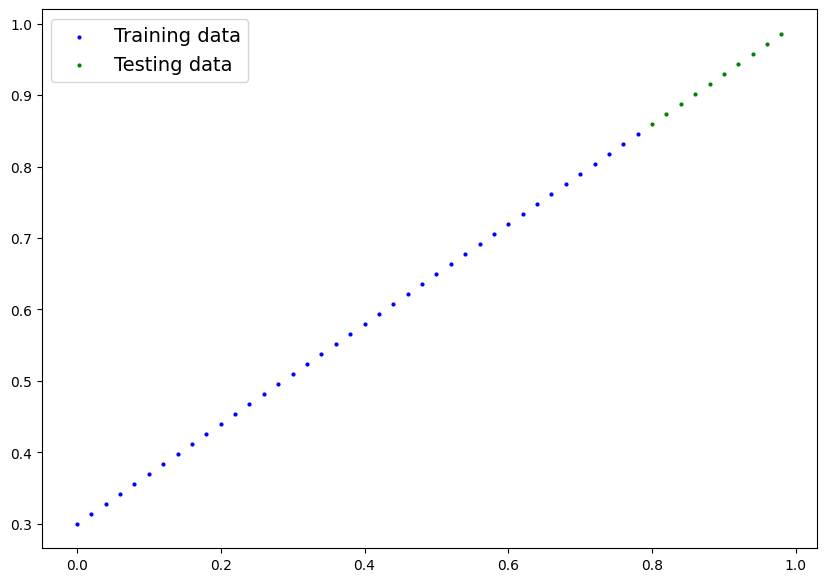

In [ ]:
plot_predictions();

##2. Build model

In [ ]:
import torch.nn as nn

In [ ]:
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)

### PyTorch model building essentials


PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

They are torch.nn, torch.optim, torch.utils.data.Dataset and torch.utils.data.DataLoader

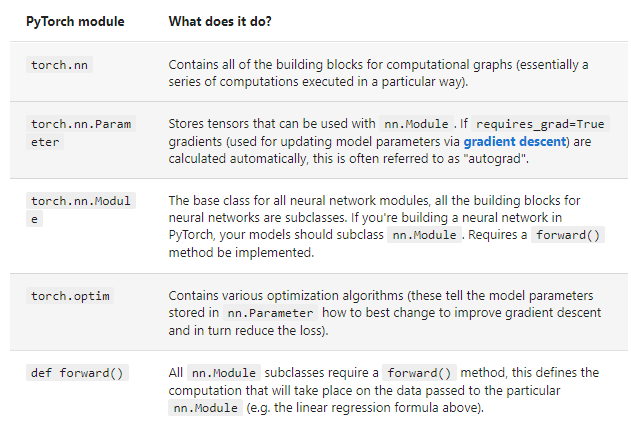

If the above sounds complex, think of like this, almost everything in a PyTorch neural network comes from torch.nn,



*   nn.Module contains the larger building blocks (layers)

*   nn.Parameter contains the smaller parameters like weights and biases (put these together to make nn.Module(s))
   

*   forward() tells the larger blocks how to make calculations on inputs (tensors full of data) within nn.Module(s)

*   torch.optim contains optimization methods on how to improve the parameters within nn.Parameter to better represent input data






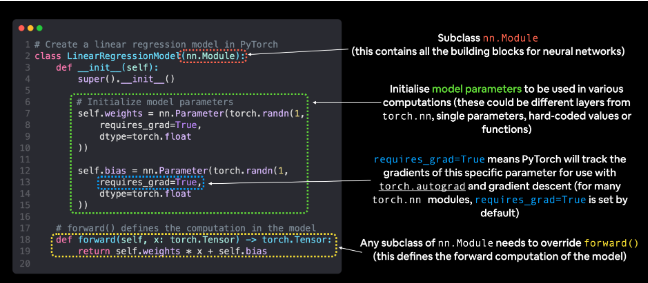

###Checking the contents of a PyTorch model


In [ ]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(40)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.9307], requires_grad=True),
 Parameter containing:
 tensor([-0.3482], requires_grad=True)]

In [ ]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.9307])), ('bias', tensor([-0.3482]))])

###Making predictions using torch.inference_mode()

In [ ]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

You probably noticed we used torch.inference_mode() as a context manager (that's what the with torch.inference_mode(): is) to make the predictions.

As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In [ ]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3964],
        [0.4150],
        [0.4336],
        [0.4522],
        [0.4709],
        [0.4895],
        [0.5081],
        [0.5267],
        [0.5453],
        [0.5639]])


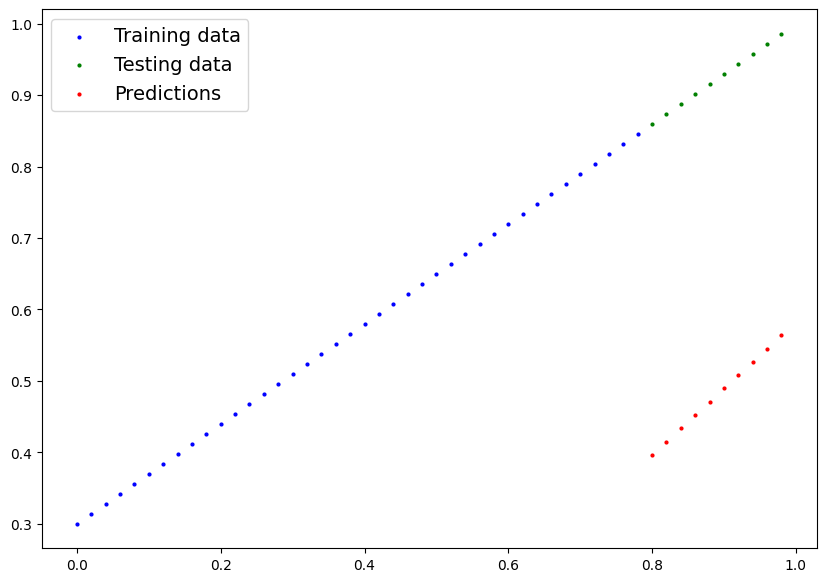

In [ ]:
plot_predictions(predictions=y_preds)

In [ ]:
y_test - y_preds

tensor([[0.4636],
        [0.4590],
        [0.4544],
        [0.4498],
        [0.4451],
        [0.4405],
        [0.4359],
        [0.4313],
        [0.4267],
        [0.4221]])

Those predictions look pretty bad...

This make sense though when you remember our model is just using random parameter values to make predictions.

It hasn't even looked at the blue dots to try to predict the green dots.

Time to change that.

##3. Train model

Right now our model is making predictions using random parameters to make calculations, it's basically guessing (randomly).

To fix that, we can update its internal parameters (I also refer to parameters as patterns), the weights and bias values we set randomly using nn.Parameter() and torch.randn() to be something that better represents the data.

We could hard code this (since we know the default values weight=0.7 and bias=0.3) but where's the fun in that?

Much of the time you won't know what the ideal parameters are for a model.

Instead, it's much more fun to write code to see if the model can try and figure them out itself.

### Creating a loss function and optimizer in PyTorch


For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a **loss function** as well as an optimizer.

The rolls of these are:

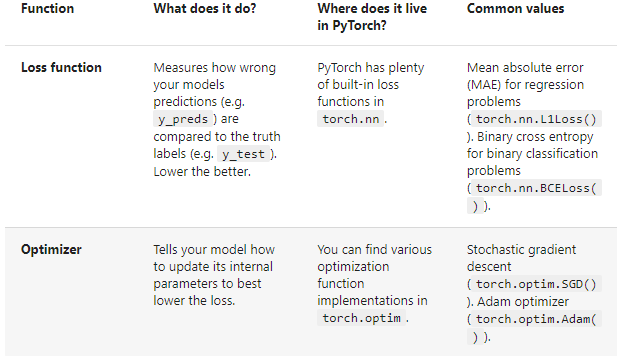

Let's create a loss function and an optimizer we can use to help improve our model.

Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

For our problem, since we're predicting a number, let's use MAE (which is under torch.nn.L1Loss()) in PyTorch as our loss function.

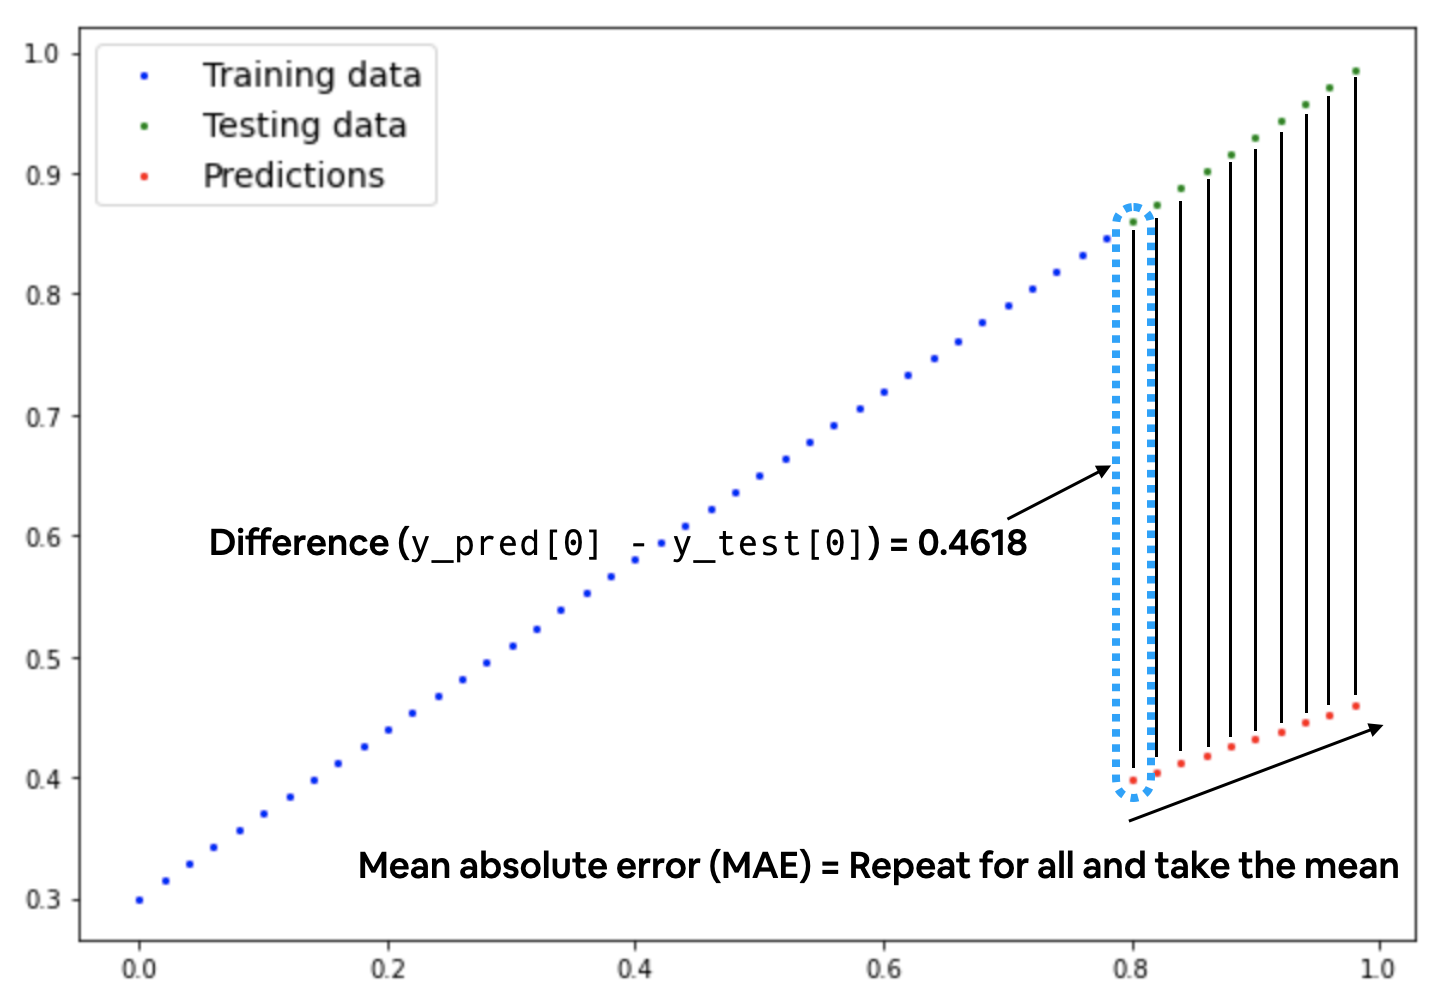

Mean absolute error (MAE, in PyTorch: torch.nn.L1Loss) measures the absolute difference between two points (predictions and labels) and then takes the mean across all examples.

And we'll use SGD, torch.optim.SGD(params, lr) where:



*   params is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).

*   lr is the **learning rate** you'd like the optimizer to update the parameters at, higher means the optimizer will try larger updates (these can sometimes be too large and the optimizer will fail to work), lower means the optimizer will try smaller updates (these can sometimes be too small and the optimizer will take too long to find the ideal values). The learning rate is considered a **hyperparameter** (because it's set by a machine learning engineer). Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling).





In [ ]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

### Creating an optimization loop in PyTorch

Now we've got a loss function and an optimizer, it's now time to create a **training loop** (and **testing loop**).

The training loop involves the model going through the training data and learning the relationships between the features and labels.

The testing loop involves going through the testing data and evaluating how good the patterns are that the model learned on the training data (the model never see's the testing data during training).

Each of these is called a "loop" because we want our model to look (loop through) at each sample in each dataset.

###PyTorch training loop


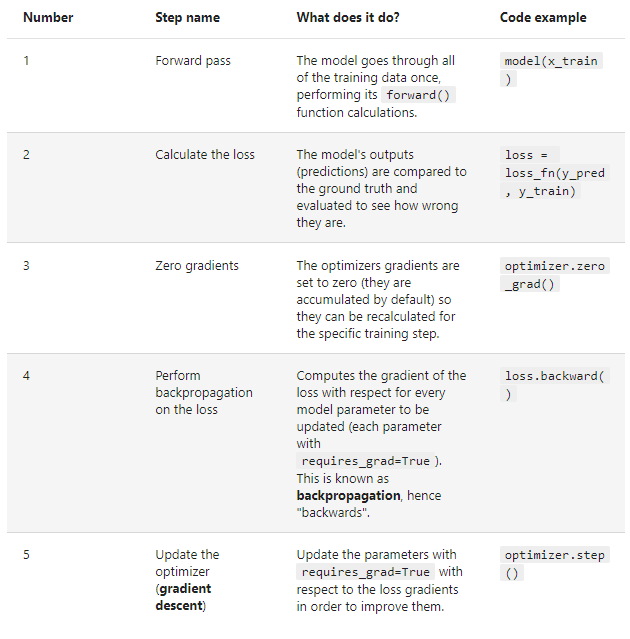

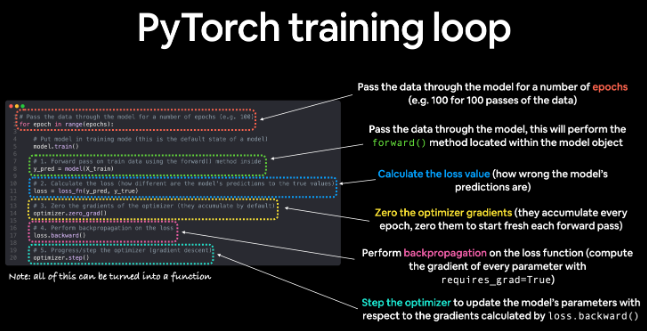

And on the ordering of things, the above is a good default order but you may see slightly different orders. Some rules of thumb:

* Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).

* Zero gradients (optimizer.zero_grad()) before stepping them (optimizer.step()).

* Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).

###PyTorch testing loop


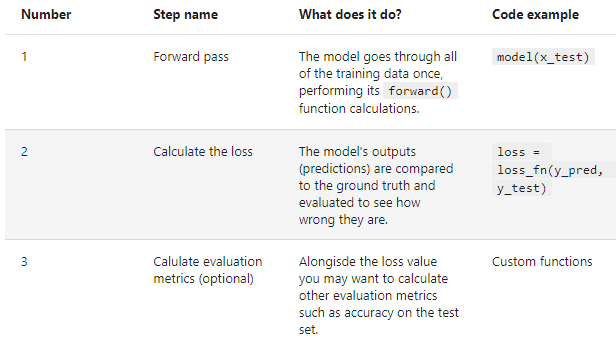

Notice the testing loop doesn't contain performing backpropagation (loss.backward()) or stepping the optimizer (optimizer.step()), this is because no parameters in the model are being changed during testing, they've already been calculated. For testing, we're only interested in the output of the forward pass through the model.

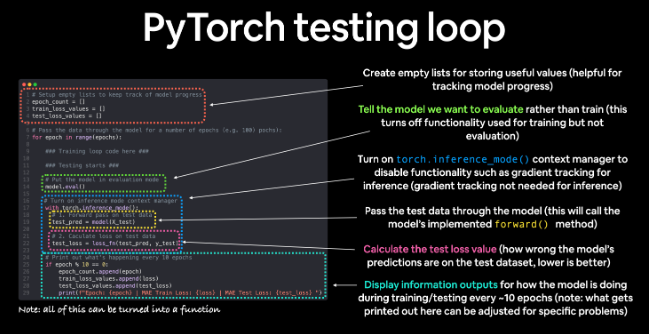

In [ ]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.06376437842845917 | MAE Test Loss: 0.14808347821235657 
Epoch: 10 | MAE Train Loss: 0.06033219024538994 | MAE Test Loss: 0.14049820601940155 
Epoch: 20 | MAE Train Loss: 0.056899625808000565 | MAE Test Loss: 0.13222572207450867 
Epoch: 30 | MAE Train Loss: 0.05346081405878067 | MAE Test Loss: 0.12395322322845459 
Epoch: 40 | MAE Train Loss: 0.050030242651700974 | MAE Test Loss: 0.1163676530122757 
Epoch: 50 | MAE Train Loss: 0.04659599810838699 | MAE Test Loss: 0.10809516906738281 
Epoch: 60 | MAE Train Loss: 0.043157193809747696 | MAE Test Loss: 0.09982268512248993 
Epoch: 70 | MAE Train Loss: 0.039728306233882904 | MAE Test Loss: 0.09223710000514984 
Epoch: 80 | MAE Train Loss: 0.036292366683483124 | MAE Test Loss: 0.08396460115909576 
Epoch: 90 | MAE Train Loss: 0.03285479545593262 | MAE Test Loss: 0.07637904584407806 
Epoch: 100 | MAE Train Loss: 0.029426347464323044 | MAE Test Loss: 0.06810656189918518 
Epoch: 110 | MAE Train Loss: 0.025988733395934105

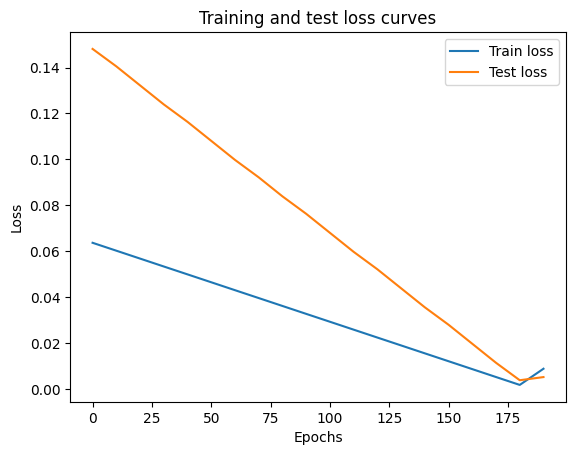

In [ ]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

The loss curves show the loss going down over time. Remember, loss is the measure of how wrong your model is, so the lower the better.

But why did the loss go down?

Well, thanks to our loss function and optimizer, the model's internal parameters (weights and bias) were updated to better reflect the underlying patterns in the data.

Let's inspect our model's .state_dict() to see see how close our model gets to the original values we set for weights and bias.

In [ ]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.7018])), ('bias', tensor([0.2903]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


It'd likely never guess them perfectly (especially when using more complicated datasets) but that's okay, often you can do very cool things with a close approximation.

This is the whole idea of machine learning and deep learning, there are some ideal values that describe our data and rather than figuring them out by hand, we can train a model to figure them out programmatically.

## 4. Making predictions with a trained PyTorch model (inference)


Once you've trained a model, you'll likely want to make predictions with it.

We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

* Set the model in evaluation mode (model.eval()).

* Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).

* All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

The first two items make sure all helpful calculations and settings PyTorch uses behind the scenes during training but aren't necessary for inference are turned off (this results in faster computation). And the third ensures that you won't run into cross-device errors.

In [ ]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8517],
        [0.8658],
        [0.8798],
        [0.8938],
        [0.9079],
        [0.9219],
        [0.9359],
        [0.9500],
        [0.9640],
        [0.9780]])

now how do they look?

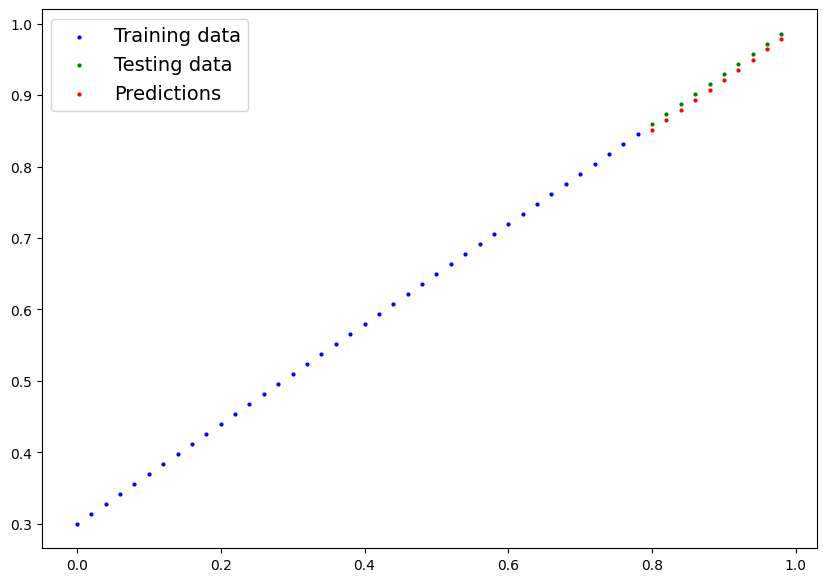

In [ ]:
plot_predictions(predictions=y_preds)

##5. Saving and loading a PyTorch model

If you've trained a PyTorch model, chances are you'll want to save it and export it somewhere.

As in, you might train it on Google Colab or your local machine with a GPU but you'd like to now export it to some sort of application where others can use it.

Or maybe you'd like to save your progress on a model and come back and load it back later.

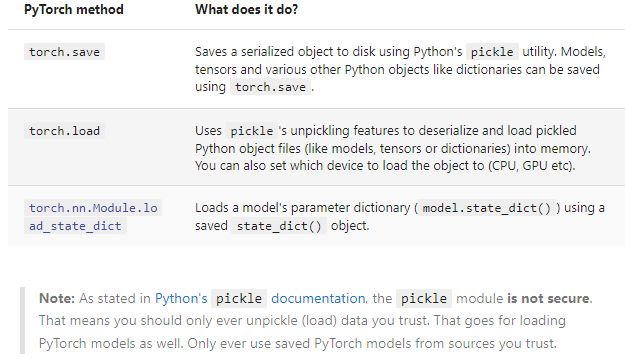

###Saving a PyTorch model's state_dict()

The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

Let's see how we can do that in a few steps:

* We'll create a directory for saving models to called models using Python's pathlib module.

* We'll create a file path to save the model to.

* We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_0.pth


In [ ]:
# Check the saved file path
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Nov  7 21:19 models/01_pytorch_workflow_model_0.pth


###Loading a saved PyTorch model's state_dict()


Since we've now got a saved model state_dict() at models/01_pytorch_workflow_model_0.pth we can now load it in using torch.nn.Module.load_state_dict(torch.load(f)) where f is the filepath of our saved model state_dict().

Why call torch.load() inside torch.nn.Module.load_state_dict()?

Because we only saved the model's state_dict() which is a dictionary of learned parameters and not the entire model, we first have to load the state_dict() with torch.load() and then pass that state_dict() to a new instance of our model (which is a subclass of nn.Module).

In [ ]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

It looks like things matched up.

Now to test our loaded model, let's perform inference with it (make predictions) on the test data.

In [ ]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

Now we've made some predictions with the loaded model, let's see if they're the same as the previous predictions.

In [ ]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

It looks like the loaded model predictions are the same as the previous model predictions (predictions made prior to saving). This indicates our model is saving and loading as expected.



##6. Putting it all together


In [ ]:
# Import PyTorch and matplotlib
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'2.1.0+cu118'

In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


###6.1 Data


In [ ]:
# Create weight and bias
weight = 0.7
bias = 0.3

# Create range values
start = 0
end = 1
step = 0.02

# Create X and y (features and labels)
X = torch.arange(start, end, step).unsqueeze(dim=1) # without unsqueeze, errors will happen later on (shapes within linear layers)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [ ]:
# Split data
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

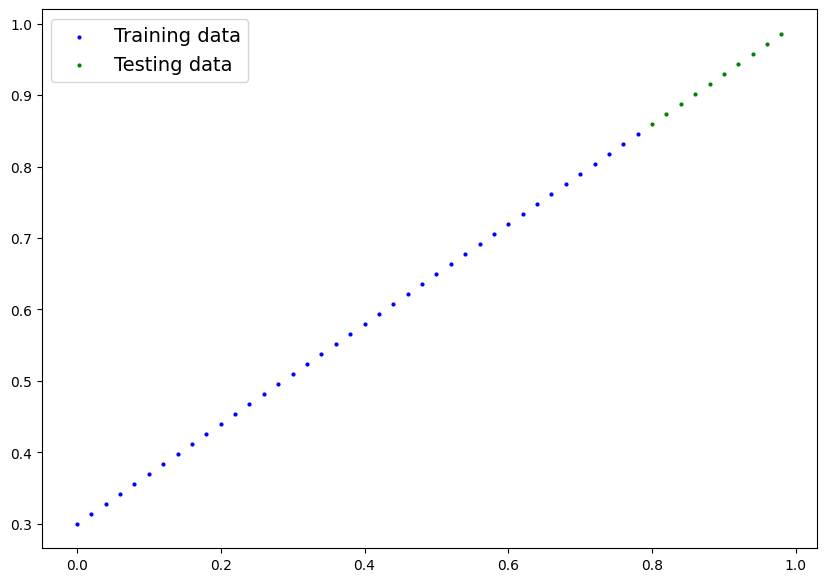

In [ ]:
# Note: If you've reset your runtime, this function won't work,
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

###6.2 Building a PyTorch linear model


We'll create the same style of model as before except this time, instead of defining the weight and bias parameters of our model manually using nn.Parameter(), we'll use nn.Linear(in_features, out_features) to do it for us.

Where in_features is the number of dimensions your input data has and out_features is the number of dimensions you'd like it to be output to.

In [ ]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer = nn.Linear(in_features=1,
                                      out_features=1)

    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1, model_1.state_dict()

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

Now let's put our model on the GPU (if it's available).


In [ ]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

In [ ]:
# Set model to GPU if it's availalble, otherwise it'll default to CPU
model_1.to(device) # the device variable was set above to be "cuda" if available or "cpu" if not
next(model_1.parameters()).device

device(type='cuda', index=0)

###6.3 Training


Time to build a training and testing loop.

First we'll need a loss function and an optimizer.

Let's use the same functions we used earlier, nn.L1Loss() and torch.optim.SGD().

We'll have to pass the new model's parameters (model.parameters()) to the optimizer for it to adjust them during training.

The learning rate of 0.01 worked well before too so let's use that again.

In [ ]:
# Create loss function
loss_fn = nn.L1Loss()

# Create optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # optimize newly created model's parameters
                            lr=0.01)

Beautiful, loss function and optimizer ready, now let's train and evaluate our model using a training and testing loop.

The only different thing we'll be doing in this step compared to the previous training loop is putting the data on the target device.

We've already put our model on the target device using model_1.to(device).

And we can do the same with the data.

That way if the model is on the GPU, the data is on the GPU (and vice versa).

Let's step things up a notch this time and set epochs=1000.

If you need a reminder of the PyTorch training loop steps, see below.

In [ ]:
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

for epoch in range(epochs):
    ### Training
    model_1.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model_1(X_train)

    # 2. Calculate loss
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model_1(X_test)

        # 2. Calculate the loss
        test_loss = loss_fn(test_pred, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Train loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 100 | Train loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 200 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 300 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 400 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 500 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 600 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 700 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 800 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 900 | Train loss: 0.0012645035749301314 | Test loss: 0.013801801018416882


Let's check the parameters our model has learned and compare them to the original parameters we hard-coded.



In [ ]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


### 6.4 Making predictions


Now we've got a trained model, let's turn on it's evaluation mode and make some predictions.



In [ ]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

If you're making predictions with data on the GPU, you might notice the output of the above has device='cuda:0' towards the end. That means the data is on CUDA device 0 (the first GPU your system has access to due to zero-indexing), if you end up using multiple GPUs in the future, this number may be higher.

Now let's plot our model's predictions.



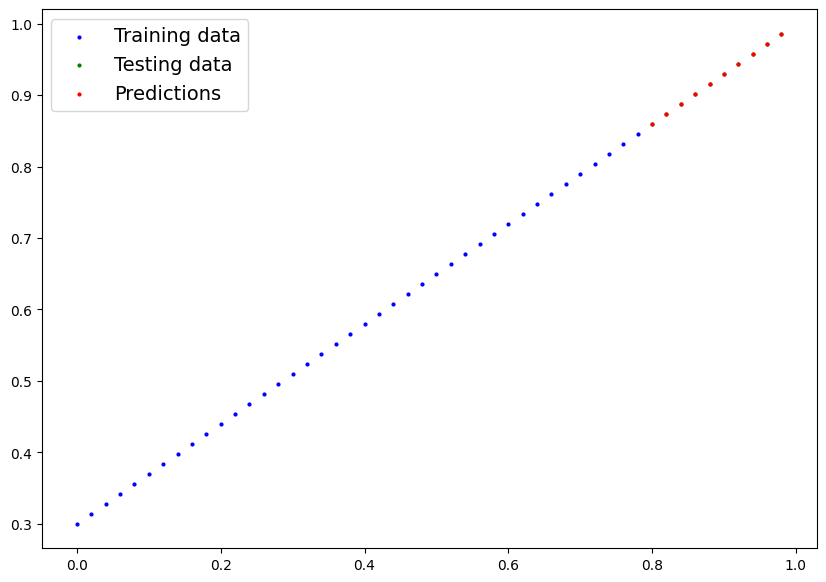

In [ ]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

###6.5 Saving and loading a model


In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/01_pytorch_workflow_model_1.pth


And just to make sure everything worked well, let's load it back in.

We'll:

* Create a new instance of the LinearRegressionModelV2() class
* Load in the model state dict using torch.nn.Module.load_state_dict()
* Send the new instance of the model to the target device (to ensure our code is device-agnostic)

In [ ]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [ ]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')